# Latent Dirichlet Allocation

This is the takehome notebook for the NLP engineer position at Contenda. 



## How did you allocate your time?
* 15 minutes familiarizing myself with the existing code and data.
* 20 minutes setting up a conda environment with jupyter and the dependencies.
* 40 minutes running the existing code to get a model trained and look at some initial results on the train data.
* 40 minutes doing some iteration and experimentation, including some refactors and annotations of the code, reviewing the output and adding some improvements to remove stopwords, and experimenting with different numbers of topics
* 30 minutes re-formatting the output into a table format
* 20 minutes experimenting with a TSNE dimensionality reduction for a clustering visualization.
* 40 minutes for this writeup (Yes, I went over the time a bit!)

## What are the tradeoffs between training a model on transcripts as a corpus versus written articles?
First of all, it seems that there's a strong motivation to develop models that can work well on transcripts, as the transcripts represent the content of media for which internal discoverability might be challenging. Because we're motivated to build models that help process these kinds of media, we'll see better results if we develop models that work well in that domain.

The differences in style and register between transcribed speech and formal written language are quite significant. Speech is often in a more informal register, so we'll see use of much more casual language than we'd expect in an article. We'll also expect to see much looser syntax, interjections, disfluencies and edits we wouldn't expect in written language.

The existing models in libraries like NLTK and spaCY we use to process our data (e.g. tokenization, POS, and lemmatization in this example) are generally trained and evaluated on corpora of formal writing (especailly news articles). This means that using transcriptions introduces some friction here, as we must either accept some negative impact to our results due to this domain mismatch, or invest in addressing these issues with things like pre- and post- processing steps or taking the time to find or train models that perform better on transcribed speech.

## What is something you'd like to try if you had another 8 hours? 3 days? 1 week?
Given another 8 hours:
* Take some more time to familiarize myself with the contents of the datasets. I'd look for things like formatting differences, domain/style differences, and common stopwords.
* Have some conversations with stakeholders to determine priorities here. What are we doing with these topic models? It's difficult to assess them or prioritize without that context.
* I'm not terribly fond of working in notebooks. I'd prefer to move most of the functions out of the notebook context and only use it for some final processing and sharing results.
* Influenced by the above, I'd spend more time pre-processing the data. I've already noticed, for example, that some of the data seem to be missing linebreaks. This could potentially be addressed with some heuristic pre-processing to re-insert breaks where we could reliably predict them with a regex pattern.
* I'd add some nicer summary statistics and visualizations. I gave some fun TSNE reduction and clustering a shot, but it's not terribly informative at this point and without taking the time to add tooltips/labels!

Given 3 days:
* Look more into other topic modeling methods. There are some good end-to-end neural methods out there that might be quick to implement and evaluate.
* Can we get more data? It's a pretty small dataset!
* If feasable with the amount of data, set up a validation dataset so I can more confidently do parameter tuning of the LDA itself and/or other models.

Given 1 week:
* Given more time, depending on the broader goals, I'd probably prefer to use a supervised labeling method and take the time to manually label a dataset.
* At this point, it would also be worth looking into the broader project pipeline and ensure that things are set up in a way that's going to be reliable and repeatable.


## What are the tradeoffs between using LDA for topic modeling vs other methods?
That LDA is unsupervised means we can quickly see what kind of distinctions arise naturally from the distributions of tokens in the documents. Especially for early exploratory work, it's great to be able to get results these without having to source or create a labeled dataset.

There are a few challenges with LDA and similar unsupervised methods, however. First, there's not really any well established way to set the correct number of topics. It's possible to look at things like perplexity and model coherence to evaluate how well a model does with a given number of topics, but there's always some complexity and subjectivity here. 

Second, the topics are associated with keywords, but there's not necessarily an intuitive mapping to something we'd normally think of as a topic. We might often be able to look at the set of associated tokens and assign some sensible topic gloss, but this isn't guaranteed and may not actually be a great representation of the model's own internal process.

Third, these topics will change if we change our training data. It can be challenging to build reliable products downstream of an LDA model, as we can't easily guarantee the stability of the topics.

## Machine transcriptions have more mistakes than human transcriptions. If we only had access to a large amount of machine transcriptions, what are some strategies we could try to still have decent topic modeling?
The first step here would be some re-working of the data preparation pipeline to be a little more tolerent of these errors. I know from experience that neither the NLTK nor spaCY sentence tokenizer or POS annotator work well on machine transcriptions. There are some basic pre-and post processing rules here that can catch a lot of the common errors and patch things back together.

Machine transcription systems are generally trained and tested on generalized domains, meaning they will often make errors in technical and specialized domains. To take a concrete example I've seen, the prior probability of the phrase "a sauna" in a general corpus is much higher than the homophonic work management platform "Asana." Given the resources, fine-tuning a transcription model to fit the domain could improve results, but this would be expensive to do per-domain. Short of that, some post-hoc correction could likely yield good results. The simplest version could be a set of pattern matchers and substitutions, but it could also be interesting to model in more depth with some kind of phonemic representation of the text in combination with token frequencies collected from in domain data. For example, we could evaluate

In [5]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from itertools import chain
import numpy as np

from gensim.models import Phrases
from gensim import corpora, models

import nltk

import boto3
import json

import os

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/kevin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/kevin/nltk_data...
[nltk_data] Downloading package stopwords to /home/kevin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kevin/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /home/kevin/nltk_data...


True

In [3]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [133]:
def build_lda_corpus(tokens, dictionary=None):
    if not dictionary:
        dictionary = corpora.Dictionary(tokens)
    
        # Consider parameterizing the no_below here?
        dictionary.filter_extremes(no_below=0)
    
    # Corpus consists of a BOW representation for each document
    corpus = [dictionary.doc2bow(tok) for tok in tokens]
    
    return corpus, dictionary

In [262]:
def ngram_tokenize(list_text):
    df = pd.DataFrame(list_text)
    df.columns = ["documents"]
    
    # Split each document into sentences. NLTK's sentence tokenizer isn't great out of the box.
    # Look into other options like spacy here and consider adding some heuristic pre
    # and post-processing rules. Great blog post by textio or grammerly on this I could dig up.
    # I also notice that some of the data is missing newline characters. Some heuristic pre-processing could
    # clean this up and improve sentence tokenization.
    df['sentences'] = df.documents.map(sent_tokenize)
    
    # Tokenize each sentence
    df['tokens_sentences'] = df['sentences'].map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
    
    # Add our POS tags to tokens
    df['POS_tokens'] = df['tokens_sentences'].map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
    df['tokens_sentences_lemmatized'] = df['POS_tokens'].map(
        lambda list_tokens_POS: [
            [
                lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
                if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
            ] 
            for tokens_POS in list_tokens_POS
        ]
    )
    
    # Lemmatize. Would be worth investigating accuracy of lemmatizer, esp. in specific domains.
    df['tokens'] = df['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
    
    df['tokens'] = df['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha()])
    
    tokens = df['tokens'].tolist()

    
    # Get bigrams and trigrams so we can use these as potential topics
    bigram_model = Phrases(tokens)
    trigram_model = Phrases(bigram_model[tokens], min_count=1)
    tokens = list(trigram_model[bigram_model[tokens]])
    
    # Let's also filter out the stopwords after generating ngrams.
    stop = set(stopwords.words('english'))
    
    # Add some common bigrams we see as well. Would do this more
    # systematically with more time!
    stop.update(("they_re", "gon_na", "it_s", "yep"))
    for i in range(len(tokens)):
        tokens[i] = [token for token in tokens[i] if token not in stop]
    
    # Add tokens back to our dataframe for reference
    df['tokens'] = tokens

    
    return tokens, df

In [263]:
def build_lda_model(corpus, dictionary, num_topics):
    lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                id2word=dictionary, \
                                passes=4, alpha=[0.01]*num_topics, \
                                eta=[0.01]*len(dictionary.keys()))
    
    return lda_model

In [264]:
def iter_texts(path):
    for f_name in os.listdir(path):
        if f_name.split('.')[-1] == 'txt':
            with open(os.path.join(path, f_name)) as f:
                yield (f_name, f.read())

In [265]:
def get_topic_labels(model, dictionary, topn=4):
    topic_labels = {}
    for i, topic in enumerate(model.get_topics()):
        topic_labels[i] = ' '.join([
            dictionary[topic_term_id] for topic_term_id, topic_term_weight in model.get_topic_terms(i, topn)
        ])
    return topic_labels

In [266]:
def get_perplexities(train_corpus, dictionary):
    for i in range(2, 25):
        model = build_lda_model(train_corpus, dictionary, i)
        print(f"{i} topic perplexity: {model.log_perplexity(train_corpus)}")

In [267]:
train_names, train_data = zip(*iter_texts('./training_transcriptions'))
test_names, test_data = zip(*iter_texts('./testing_transcriptions'))

In [268]:
train_tokens, train_df = ngram_tokenize(train_data)
train_corpus, train_dictionary = build_lda_corpus(train_tokens)

# train_df.head() # Let's take a look at what we're already doing to process the text

In [269]:
# Take a look at model perplexities for different models,
# Though we balance this with subjective informativeness of 
# numbers of topics. This would really depend on downstream use.
# Model coherence might be useful too given more time.
# get_perplexity(train_corpus, train_dictionary)

2, -9.384183747946363
3, -9.552122909688178
4, -9.659071506780863
5, -9.75389616673836
6, -9.792434719799113
7, -9.794982391811114
8, -9.880884204727359
9, -9.994193100402038
10, -10.044401817294121
11, -10.043077330799306
12, -10.0792240866462
13, -10.23724585279351
14, -10.205427309095876
15, -10.360864923548714
16, -10.46534211470692
17, -10.403951269148664
18, -10.598564625340051
19, -10.895946562298404
20, -10.945003526605488
21, -10.718562876028342
22, -11.004651568432363
23, -11.334026557048944
24, -11.043341634587847


In [270]:
model = build_lda_model(train_corpus, train_dictionary, 5)

In [271]:
topic_labels = get_topic_labels(model, train_dictionary)

In [272]:
test_tokens, test_df = ngram_tokenize(test_data)

In [273]:
test_corpus, _ = build_lda_corpus(test_tokens)

In [278]:
vector = list(model[test_corpus])
data = []
for i, name in enumerate(test_names):
    data.append(
        (
            name,
            [topic_labels[topic[0]] for topic in vector[i]],
            [{topic[0]: topic[1] for topic in vector[i]}.get(key, 0.0) for key in topic_labels.keys()],
            *[label in [topic[0] for topic in vector[i]] for label in topic_labels.keys()]
        )
    )

In [279]:
out_df = pd.DataFrame(data)
out_df.columns = ("document", "labels", "vector", *topic_labels.values())

In [280]:
out_df

,document,labels,vector,typescript twilioquest open_source event,flip language github english,snake game image chat,button corgi deploy query,react rust site javascript
0,local-development-of-serverless-functions-on-n...,"[typescript twilioquest open_source event, fli...","[0.7278668, 0.27211905, 0.0, 0.0, 0.0]",True,True,False,False,False
1,devrel-creating-high-quality-communities.txt,"[typescript twilioquest open_source event, fli...","[0.16337556, 0.83656937, 0.0, 0.0, 0.0]",True,True,False,False,False
2,find-your-next-open-source-contribution.txt,"[typescript twilioquest open_source event, fli...","[0.54691106, 0.20789461, 0.0, 0.24518697, 0.0]",True,True,False,True,False
3,simplify-and-unify-data-access-with-netlify-gr...,"[typescript twilioquest open_source event, fli...","[0.6816203, 0.10434863, 0.13942303, 0.07460345...",True,True,True,True,False
4,devrel-the-kick-ass-curve-steve-pousty.txt,"[typescript twilioquest open_source event, fli...","[0.25111735, 0.061097283, 0.0, 0.6877482, 0.0]",True,True,False,True,False
5,create-playful-interactive-animations.txt,"[typescript twilioquest open_source event, fli...","[0.24619126, 0.10233799, 0.026559336, 0.618126...",True,True,True,True,False
6,build-a-live-voting-app.txt,"[typescript twilioquest open_source event, fli...","[0.40743235, 0.07562465, 0.0, 0.51693064, 0.0]",True,True,False,True,False
7,jamstack-and-headless-cms-sites-using-strapi.txt,"[typescript twilioquest open_source event, fli...","[0.3320111, 0.08802282, 0.37302688, 0.20693406...",True,True,True,True,False
8,devrel-building-an-enterprise-developer-market...,"[typescript twilioquest open_source event, fli...","[0.24860881, 0.25960484, 0.31301042, 0.1787597...",True,True,True,True,False
9,devrel-tomtom-first-year-of-dev-rel.txt,"[typescript twilioquest open_source event, fli...","[0.25939736, 0.47420618, 0.060875356, 0.153870...",True,True,True,True,True


In [305]:
import sklearn
from sklearn.manifold import TSNE
vectors = np.array(list(out_df['vector']))
vec2d = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(vectors)

In [306]:
x, y = zip(*vec2d)

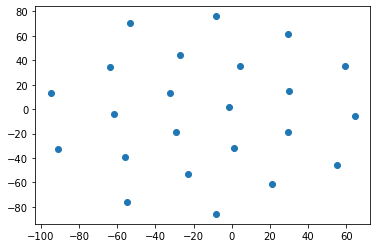

In [308]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()